# MODEL FUSIONS

In [21]:
import cv2
import os
import keras
import sklearn
import numpy as np 
from os import listdir 
import tensorflow  as tf 
from matplotlib import cm  
import matplotlib.pyplot as plt
from os.path import isfile , join 
from tensorflow import expand_dims
from keras.models import load_model
from keras.layers import concatenate
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from keras.models import Sequential , Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator 
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.layers import Dense , Dropout , Flatten , MaxPooling2D 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from keras.layers import Conv2D , Conv2DTranspose , GlobalAveragePooling2D 
from keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Reshape, Concatenate, Dropout , MaxPooling1D, Flatten

In [22]:
IMG_HEIGHT,IMG_WIDTH=128,128
BATCH_SIZE=1

#### DATASET LOADING

In [23]:
train_dir = "Brain_Dataset/Training/"
test_dir = "Brain_Dataset/Testing/"

In [24]:
# This will randomly generates tensorflow tensors of 32 batch size of whole dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  subset="training",
  validation_split=0.2,
  seed=24,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=24,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=24,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 4117 files belonging to 3 classes.
Using 3294 files for training.
Found 4117 files belonging to 3 classes.
Using 823 files for validation.
Found 906 files belonging to 3 classes.


In [25]:
# Update the number of output units in the final layer of the model to match the number of classes in the dataset
num_classes = len(train_dataset.class_names)

## MODEL#1: INCEPTIONV3 MODEL

In [26]:
inception = InceptionV3(weights = "imagenet" , 
                       include_top = False , 
                       input_shape = (128 , 128 , 3)) 
for layer in inception.layers:
    layer.trainable = False 

#### TYPE OF LAYERS ALONG WITH BOOLEAN REPRESENTING IF THEY ARE ALLOWED TO TRAIN OR NOT

In [27]:
def addtopmodelinception(bottom_model , num_classes):
    top_model = bottom_model.output 
    top_model = GlobalAveragePooling2D()(top_model) 
    top_model = Dense(1024 , activation = "relu")(top_model)
    top_model = Dense(1024 , activation = "relu")(top_model)
    top_model = Dense(512 , activation = "relu")(top_model) 
    top_model = Dense(128 , activation = "relu")(top_model)
    top_model = Dense(num_classes , activation = "softmax")(top_model)
    return top_model 

In [28]:
num_classes = 3
FCHead = addtopmodelinception(inception , num_classes) 
model_1 = Model(inputs = inception.inputs , outputs = FCHead)
model_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 63, 63, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 63, 63, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [29]:
modelcheck = ModelCheckpoint("D:/Clients/Client1/models_weights/googlenet.h5" , 
                             monitor = "val_loss" , 
                             mode = "min" , 
                             verbose =1 , 
                             save_best_only = True)
early_stop = EarlyStopping(monitor = "val_loss" , 
                           min_delta = 0 , 
                           patience = 2 ,
                           verbose = 1 ,
                           restore_best_weights = True) 
reducelr = ReduceLROnPlateau(monitor = "val_loss" , 
                             min_delta = 0.0001 , 
                             patience = 2 , 
                             verbose = 1 , 
                             factor =0.2)
callbacks = [modelcheck , early_stop , reducelr] 

optimizer = RMSprop(learning_rate=0.001)
model_1.compile(loss='sparse_categorical_crossentropy',
              optimizer = optimizer, 
              metrics = ["accuracy"])

In [30]:
epochs = 50
history = model_1.fit(train_dataset,
            batch_size = BATCH_SIZE,
            validation_data = validation_dataset,
            epochs = epochs)

Epoch 1/50
3294/3294 [==============================] - 59s 17ms/step - loss: 1.9463 - accuracy: 0.5899 - val_loss: 0.7093 - val_accuracy: 0.7072
Epoch 2/50
3294/3294 [==============================] - 55s 17ms/step - loss: 1.0130 - accuracy: 0.6952 - val_loss: 1.2907 - val_accuracy: 0.7375
Epoch 3/50
3294/3294 [==============================] - 55s 17ms/step - loss: 1.0273 - accuracy: 0.7189 - val_loss: 1.8910 - val_accuracy: 0.6950
Epoch 4/50
3294/3294 [==============================] - 54s 16ms/step - loss: 0.9695 - accuracy: 0.7401 - val_loss: 0.9682 - val_accuracy: 0.7728
Epoch 5/50
3294/3294 [==============================] - 56s 17ms/step - loss: 0.9820 - accuracy: 0.7359 - val_loss: 1.0660 - val_accuracy: 0.7740
Epoch 6/50
3294/3294 [==============================] - 57s 17ms/step - loss: 1.0776 - accuracy: 0.7447 - val_loss: 0.6444 - val_accuracy: 0.7278
Epoch 7/50
3294/3294 [==============================] - 54s 17ms/step - loss: 1.0314 - accuracy: 0.7401 - val_loss: 1.0944 -

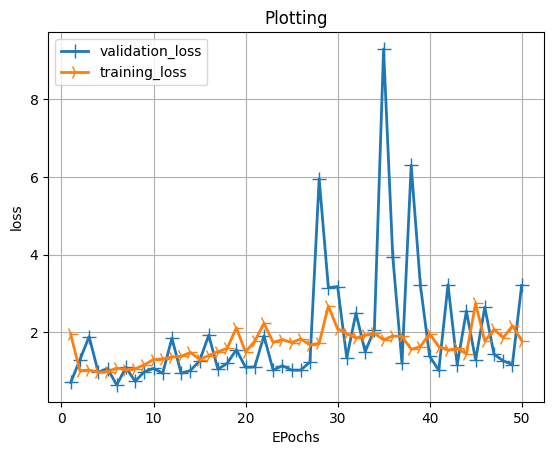

In [31]:
history_dict = history.history 
loss_val = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1 , len(loss_val)+1)
line1 = plt.plot(epochs , val_loss , label = "validation_loss")
line2 = plt.plot(epochs , loss_val , label = "training_loss")
plt.setp(line1 , linewidth = 2.0  , marker = "+" , markersize = 10.0)
plt.setp(line2 , linewidth = 2.0  , marker = "4" , markersize = 10.0)
plt.title("Plotting")
plt.xlabel("EPochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

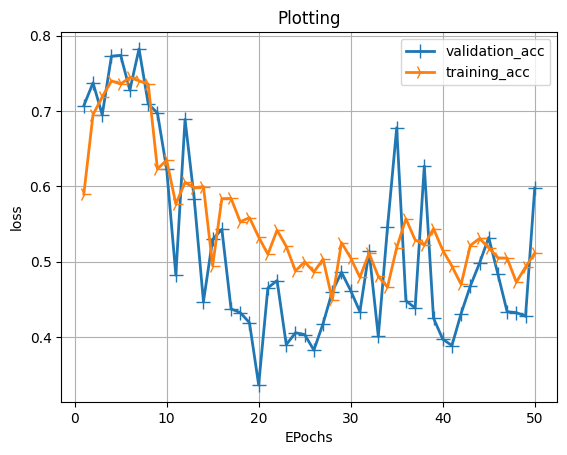

In [32]:
history_dict = history.history 
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]
epochs = range(1 , len(accuracy)+1)
line1 = plt.plot(epochs , val_accuracy , label = "validation_acc")
line2 = plt.plot(epochs , accuracy , label = "training_acc")
plt.setp(line1 , linewidth = 2.0 ,marker = "+" , markersize = 10.0)
plt.setp(line2 , linewidth = 2.0 ,marker = "4" , markersize = 10.0)
plt.title("Plotting")
plt.xlabel("EPochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

## MODEL#2: MOBILENET MODEL

In [33]:
mobilenet = MobileNet(weights = "imagenet" , 
                      include_top  = False , 
                      input_shape = (128 , 128 , 3))  
for layer in mobilenet.layers:
  layer.trainable = False 

In [34]:
def addtopmodelmobilenet(bottom_model , num_classes):
  top_model = bottom_model.output 
  top_model = GlobalAveragePooling2D()(top_model) 
  top_model = Dense(1024 , activation = "relu")(top_model) 
  top_model = Dense(1024 , activation = "relu")(top_model) 
  top_model = Dense(512 , activation = "relu")(top_model) 
  top_model = Dense(128 , activation = "relu")(top_model)
  top_model = Dense(num_classes , activation = "softmax")(top_model) 
  return top_model 

In [35]:
num_classes = 3
FCHead = addtopmodelmobilenet(mobilenet , num_classes) 
model_2 = Model(inputs = mobilenet.inputs , outputs = FCHead) 
model_2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0   

In [36]:
modelcheckpoint = ModelCheckpoint("D:/Clients/Client1/models_weights/mobilenet.h5" , 
                                  monitor = "val_loss" , 
                                  mode = "min" , 
                                  save_best_only = True , 
                                  verbose = 1) 
earlystop = EarlyStopping(monitor = "val_loss" , 
                          min_delta = 0 ,  
                          patience = 2,
                          verbose = 1 , 
                          restore_best_weights = True) 
reducelr = ReduceLROnPlateau(monitor = "val_loss" , 
                             factor = 0.2 , 
                             min_delta = 0.00001 , 
                             patience = 2 , 
                             verbose = 1)  
callbacks = [modelcheckpoint , earlystop , reducelr] 

model_2.compile(loss='sparse_categorical_crossentropy' , 
              optimizer = RMSprop(learning_rate = 0.001 ) , 
              metrics = ["accuracy"])

In [37]:
epochs = 50
history = model_2.fit(train_dataset ,
                    epochs = epochs , 
                    batch_size = BATCH_SIZE , 
                    validation_data = validation_dataset , 
                    callbacks = callbacks) 

Epoch 1/50
3294/3294 [==============================] - 23s 7ms/step - loss: 0.8662 - accuracy: 0.7155 - val_loss: 0.8389 - val_accuracy: 0.7217

Epoch 00001: val_loss improved from inf to 0.83887, saving model to D:/Clients/Client1/models_weights\mobilenet.h5
Epoch 2/50
3294/3294 [==============================] - 21s 6ms/step - loss: 0.7769 - accuracy: 0.8127 - val_loss: 0.7433 - val_accuracy: 0.8457

Epoch 00002: val_loss improved from 0.83887 to 0.74334, saving model to D:/Clients/Client1/models_weights\mobilenet.h5
Epoch 3/50
3294/3294 [==============================] - 23s 7ms/step - loss: 0.7752 - accuracy: 0.8327 - val_loss: 0.9135 - val_accuracy: 0.8518

Epoch 00003: val_loss did not improve from 0.74334
Epoch 4/50
3294/3294 [==============================] - 23s 7ms/step - loss: 0.8464 - accuracy: 0.8403 - val_loss: 1.2381 - val_accuracy: 0.7740

Epoch 00004: val_loss did not improve from 0.74334
Restoring model weights from the end of the best epoch.

Epoch 00004: ReduceLROn

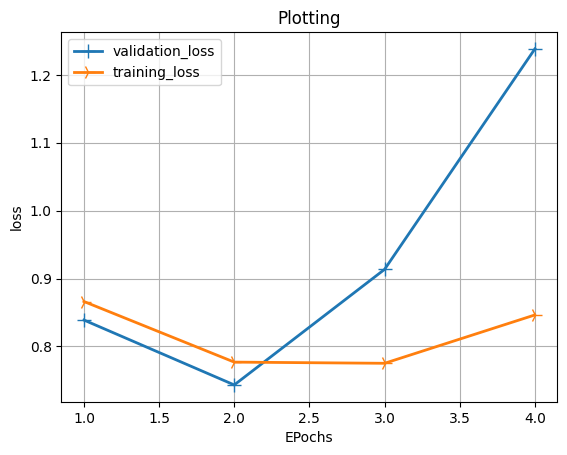

In [38]:
history_dict = history.history 
loss_val = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1 , len(loss_val)+1)
line1 = plt.plot(epochs , val_loss , label = "validation_loss")
line2 = plt.plot(epochs , loss_val , label = "training_loss")
plt.setp(line1 , linewidth = 2.0  , marker = "+" , markersize = 10.0)
plt.setp(line2 , linewidth = 2.0  , marker = "4" , markersize = 10.0)
plt.title("Plotting")
plt.xlabel("EPochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

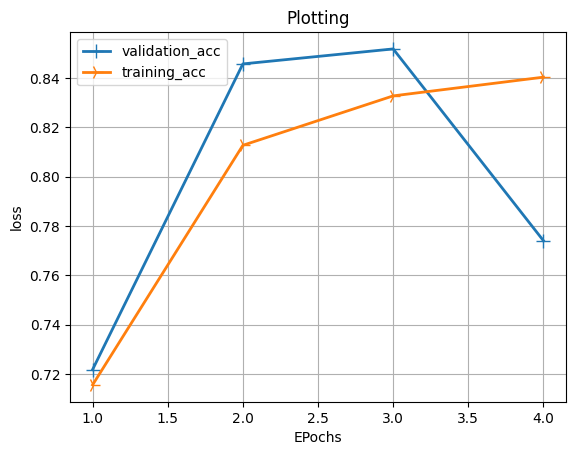

In [39]:
history_dict = history.history 
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]
epochs = range(1 , len(accuracy)+1)
line1 = plt.plot(epochs , val_accuracy , label = "validation_acc")
line2 = plt.plot(epochs , accuracy , label = "training_acc")
plt.setp(line1 , linewidth = 2.0 ,marker = "+" , markersize = 10.0)
plt.setp(line2 , linewidth = 2.0 ,marker = "4" , markersize = 10.0)
plt.title("Plotting")
plt.xlabel("EPochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

## MODEL#3: VGG19 MODEL

In [40]:
vgg19 = VGG19(weights = "imagenet" , 
              include_top = False , 
              input_shape = (128 , 128 , 3)) 
for layer in vgg19.layers:
  layer.trainable = False 

In [41]:
def addtopmodelvgg19(bottom_model , num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model) 
  top_model = Dense(1024 , activation = "relu")(top_model) 
  top_model = Dense(1024 , activation = "relu")(top_model) 
  top_model = Dense(512 , activation = "relu")(top_model)  
  top_model = Dense(128 , activation = "relu")(top_model)
  top_model = Dense(num_classes , activation = "softmax")(top_model) 
  return top_model

In [42]:
num_classes = 3
FCHead = addtopmodelvgg19(vgg19 , num_classes) 
model_3 = Model(inputs = vgg19.inputs , outputs = FCHead) 
model_3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [43]:
modelcheck = ModelCheckpoint("D:/Clients/Client1/models_weights/vgg19.h5" , 
                             monitor = "val_loss" , 
                             mode = "min" , 
                             verbose =1 , 
                             save_best_only = True)
early_stop = EarlyStopping(monitor = "val_loss" , 
                           min_delta = 0 , 
                           patience = 4 ,
                           verbose = 1 ,
                           restore_best_weights = True) 
reducelr = ReduceLROnPlateau(monitor = "val_loss" , 
                             min_delta = 0.0001 , 
                             patience = 4 , 
                             verbose = 1 , 
                             factor =0.2)
callbacks = [modelcheck , early_stop , reducelr] 

model_3.compile(loss='sparse_categorical_crossentropy' , 
              optimizer = RMSprop(learning_rate = 0.001) , 
              metrics = ["accuracy"])

In [44]:
epochs = 50
history = model_3.fit(train_dataset , 
            epochs = epochs , 
            batch_size = BATCH_SIZE , 
            validation_data = validation_dataset , 
            callbacks = callbacks)

Epoch 1/50
3294/3294 [==============================] - 24s 7ms/step - loss: 0.9617 - accuracy: 0.7001 - val_loss: 2.2811 - val_accuracy: 0.7910

Epoch 00001: val_loss improved from inf to 2.28108, saving model to D:/Clients/Client1/models_weights\vgg19.h5
Epoch 2/50
3294/3294 [==============================] - 23s 7ms/step - loss: 0.9807 - accuracy: 0.7848 - val_loss: 1.4574 - val_accuracy: 0.8262

Epoch 00002: val_loss improved from 2.28108 to 1.45737, saving model to D:/Clients/Client1/models_weights\vgg19.h5
Epoch 3/50
3294/3294 [==============================] - 24s 7ms/step - loss: 1.1349 - accuracy: 0.8021 - val_loss: 0.6231 - val_accuracy: 0.8299

Epoch 00003: val_loss improved from 1.45737 to 0.62310, saving model to D:/Clients/Client1/models_weights\vgg19.h5
Epoch 4/50
3294/3294 [==============================] - 24s 7ms/step - loss: 1.0953 - accuracy: 0.7945 - val_loss: 0.8799 - val_accuracy: 0.7351

Epoch 00004: val_loss did not improve from 0.62310
Epoch 5/50
3294/3294 [==

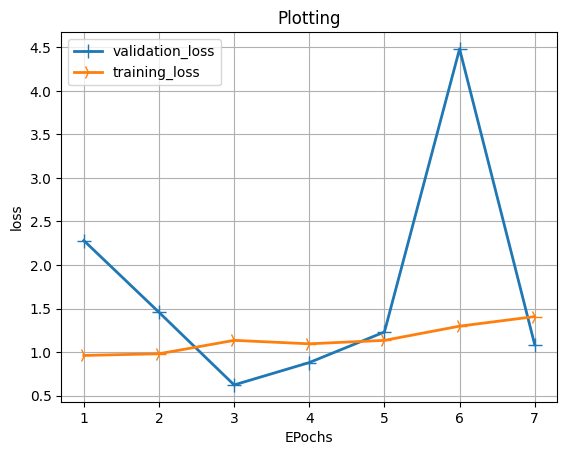

In [45]:
history_dict = history.history 
loss_val = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1 , len(loss_val)+1)
line1 = plt.plot(epochs , val_loss , label = "validation_loss")
line2 = plt.plot(epochs , loss_val , label = "training_loss")
plt.setp(line1 , linewidth = 2.0  , marker = "+" , markersize = 10.0)
plt.setp(line2 , linewidth = 2.0  , marker = "4" , markersize = 10.0)
plt.title("Plotting")
plt.xlabel("EPochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

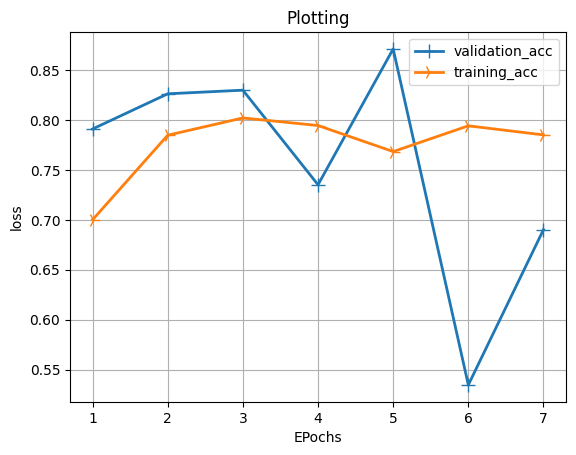

In [46]:
history_dict = history.history 
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]
epochs = range(1 , len(accuracy)+1)
line1 = plt.plot(epochs , val_accuracy , label = "validation_acc")
line2 = plt.plot(epochs , accuracy , label = "training_acc")
plt.setp(line1 , linewidth = 2.0 ,marker = "+" , markersize = 10.0)
plt.setp(line2 , linewidth = 2.0 ,marker = "4" , markersize = 10.0)
plt.title("Plotting")
plt.xlabel("EPochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

In [79]:
_ , test_acc = model_3.evaluate(test_dataset , steps = None , callbacks = None , max_queue_size = 10 , workers = 1 , use_multiprocessing=False) 
print("test_acc" , test_acc *100)

906/906 [==============================] - 4s 4ms/step - loss: 38.3966 - accuracy: 0.3311
test_acc 33.11258256435394


### FUSING MODELS WAY # 1

In [48]:
# Define the combined model architecture
input_inception = model_1.input
input_mobilenet = model_2.input
input_vgg19 = model_3.input

output_inception = model_1.output
output_mobilenet = model_2.output
output_vgg19 = model_3.output

combined_predictions = concatenate([output_inception, output_mobilenet, output_vgg19])
combined_model = Model(inputs=[input_inception, input_mobilenet, input_vgg19], outputs=combined_predictions)

In [49]:
# Compile the combined model with appropriate loss and metrics
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [50]:
features = []
labels_list = []
for images, labels in train_dataset:
    features.extend(images)
    labels_list.extend(labels)

In [51]:
features = np.array(features)
labels_list = np.array(labels_list)

In [52]:
featuresV = []
labels_listV = []
for images, labels in validation_dataset:
    featuresV.extend(images)
    labels_listV.extend(labels)

In [53]:
featuresV = np.array(featuresV)
labels_listV = np.array(labels_listV)

In [54]:
t1 = features
t2 = features
t3 = features

In [55]:
v1 = featuresV
v2 = featuresV
v3 = featuresV

In [56]:
# Train the combined model
combined_model.fit([t1, t2, t3], labels_list,
                   validation_data=([v1, v2, v3], labels_listV),
                   batch_size=1, epochs=50)

Epoch 1/50
3294/3294 [==============================] - 74s 21ms/step - loss: 11.5931 - accuracy: 0.3361 - val_loss: 11.8702 - val_accuracy: 0.3317
Epoch 2/50
3294/3294 [==============================] - 70s 21ms/step - loss: 12.0883 - accuracy: 0.3182 - val_loss: 11.8702 - val_accuracy: 0.3317
Epoch 3/50
3294/3294 [==============================] - 73s 22ms/step - loss: 12.0883 - accuracy: 0.3182 - val_loss: 11.8702 - val_accuracy: 0.3317
Epoch 4/50
3294/3294 [==============================] - 71s 21ms/step - loss: 12.0883 - accuracy: 0.3182 - val_loss: 11.8702 - val_accuracy: 0.3317
Epoch 5/50
3294/3294 [==============================] - 70s 21ms/step - loss: 12.0883 - accuracy: 0.3182 - val_loss: 11.8702 - val_accuracy: 0.3317
Epoch 6/50
3294/3294 [==============================] - 72s 22ms/step - loss: 12.0883 - accuracy: 0.3182 - val_loss: 11.8702 - val_accuracy: 0.3317
Epoch 7/50
3294/3294 [==============================] - 70s 21ms/step - loss: 12.0883 - accuracy: 0.3182 - val_l

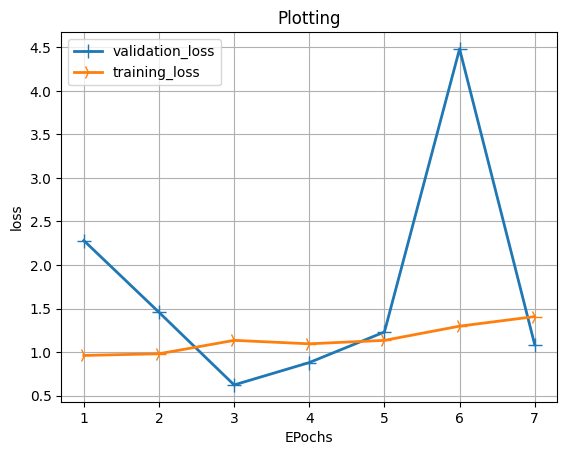

In [57]:
history_dict = history.history 
loss_val = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1 , len(loss_val)+1)
line1 = plt.plot(epochs , val_loss , label = "validation_loss")
line2 = plt.plot(epochs , loss_val , label = "training_loss")
plt.setp(line1 , linewidth = 2.0  , marker = "+" , markersize = 10.0)
plt.setp(line2 , linewidth = 2.0  , marker = "4" , markersize = 10.0)
plt.title("Plotting")
plt.xlabel("EPochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

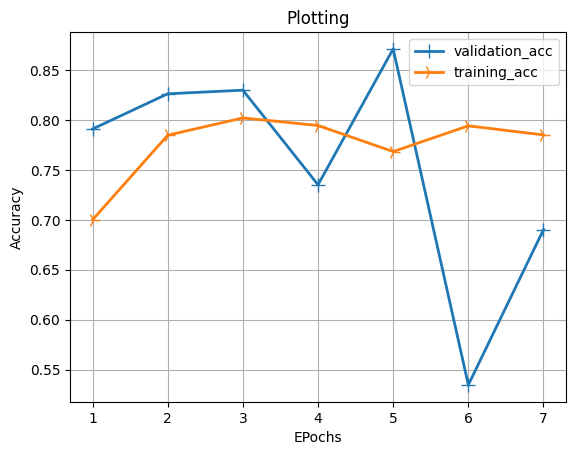

In [58]:
history_dict = history.history 
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]
epochs = range(1 , len(accuracy)+1)
line1 = plt.plot(epochs , val_accuracy , label = "validation_acc")
line2 = plt.plot(epochs , accuracy , label = "training_acc")
plt.setp(line1 , linewidth = 2.0 ,marker = "+" , markersize = 10.0)
plt.setp(line2 , linewidth = 2.0 ,marker = "4" , markersize = 10.0)
plt.title("Plotting")
plt.xlabel("EPochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [60]:
# # Evaluate the combined model on test dataset
# combined_model_accuracy = combined_model.evaluate([test_dataset, test_dataset, test_dataset])
# print("Combined Model Accuracy: ", combined_model_accuracy)

# # Evaluate InceptionV3 model on test dataset
# inception_accuracy = model.evaluate(test_dataset)
# print("InceptionV3 Model Accuracy: ", inception_accuracy)

# # Evaluate MobileNet model on test dataset
# mobilenet_accuracy = model_2.evaluate(test_dataset)
# print("MobileNet Model Accuracy: ", mobilenet_accuracy)

# # Evaluate VGG19 model on test dataset
# vgg19_accuracy = model_3.evaluate(test_dataset)
# print("VGG19 Model Accuracy: ", vgg19_accuracy)

### FUSING MODELS WAY # 2 (PREFERED)

In [61]:
inception_model_1 = Sequential()

inception = InceptionV3(weights = "imagenet" , 
                       include_top = False , 
                       input_shape = (128 , 128 , 3)) 

for layer in inception.layers:
    layer.trainable = False

inception_model_1.add(inception)

inception_model_1.add(Flatten())
inception_model_1.add(Dense(1024 , activation = "relu"))
inception_model_1.add(Dense(1024 , activation = "relu"))
inception_model_1.add(Dense(512 , activation = "relu"))
inception_model_1.add(Dense(128 , activation = "relu"))

mobilenet_model_2 = Sequential()

mobilenet = MobileNet(weights = "imagenet" , 
                      include_top  = False , 
                      input_shape = (128 , 128 , 3))  

for layer in mobilenet.layers:
  layer.trainable = False 

mobilenet_model_2.add(mobilenet)

mobilenet_model_2.add(Flatten())
mobilenet_model_2.add(Dense(1024 , activation = "relu"))
mobilenet_model_2.add(Dense(1024 , activation = "relu"))
mobilenet_model_2.add(Dense(512 , activation = "relu"))
mobilenet_model_2.add(Dense(128 , activation = "relu"))

vgg19_model_3 = Sequential()

vgg19 = VGG19(weights = "imagenet" , 
              include_top = False , 
              input_shape = (128 , 128 , 3))

for layer in vgg19.layers:
  layer.trainable = False 

vgg19_model_3.add(vgg19)

vgg19_model_3.add(Flatten())
vgg19_model_3.add(Dense(1024 , activation = "relu"))
vgg19_model_3.add(Dense(1024 , activation = "relu"))
vgg19_model_3.add(Dense(512 , activation = "relu"))
vgg19_model_3.add(Dense(128 , activation = "relu"))

In [62]:
merged = Concatenate()([inception_model_1.output, mobilenet_model_2.output, vgg19_model_3.output])

In [63]:
output = Dense(3, activation='softmax')(merged)

In [64]:
model_final = Model(inputs=[inception_model_1.input, mobilenet_model_2.input, vgg19_model_3.input], outputs=[output])

In [65]:
model_final.compile(loss='sparse_categorical_crossentropy' , 
              optimizer='adam', 
              metrics = ["accuracy"])

In [66]:
epochs = 50
history = model_final.fit([t1, t2, t3], labels_list, 
            epochs = epochs , 
            batch_size = BATCH_SIZE , 
            validation_data=([v1, v2, v3], labels_listV))

Epoch 1/50
3294/3294 [==============================] - 87s 25ms/step - loss: 2.3916 - accuracy: 0.7383 - val_loss: 0.4073 - val_accuracy: 0.8518
Epoch 2/50
3294/3294 [==============================] - 82s 25ms/step - loss: 0.5506 - accuracy: 0.8388 - val_loss: 0.3980 - val_accuracy: 0.8384
Epoch 3/50
3294/3294 [==============================] - 77s 23ms/step - loss: 0.3683 - accuracy: 0.8807 - val_loss: 0.3763 - val_accuracy: 0.8651
Epoch 4/50
3294/3294 [==============================] - 79s 24ms/step - loss: 0.3319 - accuracy: 0.9144 - val_loss: 0.2482 - val_accuracy: 0.9004
Epoch 5/50
3294/3294 [==============================] - 79s 24ms/step - loss: 0.2357 - accuracy: 0.9353 - val_loss: 0.3330 - val_accuracy: 0.9101
Epoch 6/50
3294/3294 [==============================] - 81s 25ms/step - loss: 0.2530 - accuracy: 0.9447 - val_loss: 0.4191 - val_accuracy: 0.9186
Epoch 7/50
3294/3294 [==============================] - 80s 24ms/step - loss: 0.1196 - accuracy: 0.9651 - val_loss: 0.4819 -

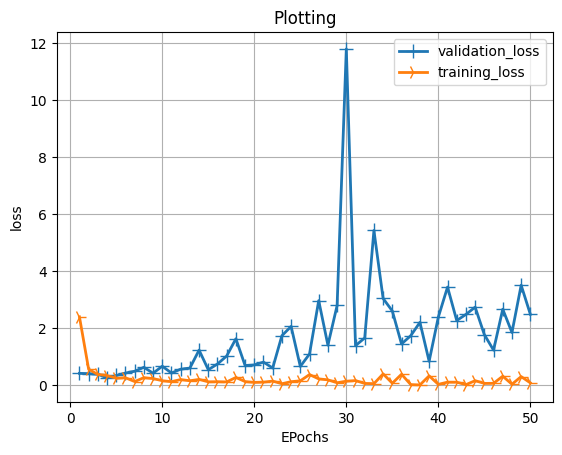

In [67]:
history_dict = history.history 
loss_val = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1 , len(loss_val)+1)
line1 = plt.plot(epochs , val_loss , label = "validation_loss")
line2 = plt.plot(epochs , loss_val , label = "training_loss")
plt.setp(line1 , linewidth = 2.0  , marker = "+" , markersize = 10.0)
plt.setp(line2 , linewidth = 2.0  , marker = "4" , markersize = 10.0)
plt.title("Plotting")
plt.xlabel("EPochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

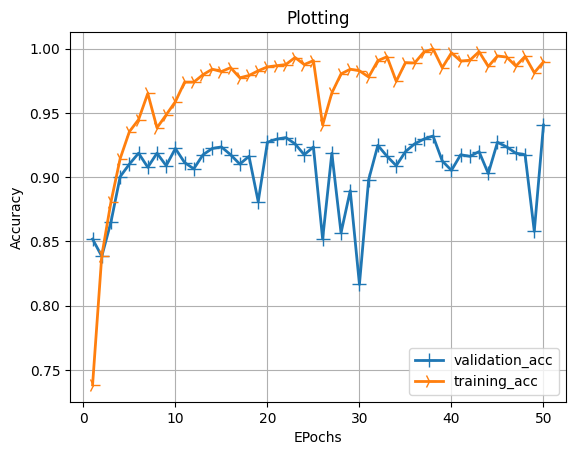

In [68]:
history_dict = history.history 
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]
epochs = range(1 , len(accuracy)+1)
line1 = plt.plot(epochs , val_accuracy , label = "validation_acc")
line2 = plt.plot(epochs , accuracy , label = "training_acc")
plt.setp(line1 , linewidth = 2.0 ,marker = "+" , markersize = 10.0)
plt.setp(line2 , linewidth = 2.0 ,marker = "4" , markersize = 10.0)
plt.title("Plotting")
plt.xlabel("EPochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### PREDICTION

In [72]:
featuresT = []
labels_listT = []
for images, labels in test_dataset:
    featuresT.extend(images)
    labels_listT.extend(labels)

featuresT = np.array(featuresT)
labels_listT = np.array(labels_listT)

test1 = featuresT
test2 = featuresT
test3 = featuresT

In [76]:
predictions = model_final.predict([test1, test2, test3])

In [82]:
predicted_classes = predictions.argmax(axis=-1)

In [84]:
predicted_classes

array([0, 1, 0, 2, 2, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 2, 0,
       1, 0, 2, 2, 0, 1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2,
       2, 1, 2, 1, 1, 2, 2, 2, 1, 0, 2, 2, 1, 1, 0, 2, 0, 1, 2, 2, 1, 1,
       0, 2, 0, 1, 0, 2, 2, 0, 0, 2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 0,
       2, 0, 1, 1, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 0, 2, 1, 1, 1,
       0, 0, 0, 0, 1, 2, 2, 1, 2, 2, 1, 1, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2,
       1, 1, 0, 2, 2, 2, 2, 2, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 0, 1, 2, 1,
       1, 1, 0, 0, 0, 2, 2, 1, 1, 2, 2, 0, 2, 0, 1, 0, 1, 2, 0, 1, 0, 1,
       0, 2, 0, 0, 1, 0, 1, 2, 1, 0, 2, 0, 2, 1, 2, 0, 1, 0, 0, 1, 2, 1,
       1, 0, 0, 0, 1, 2, 1, 2, 2, 0, 0, 0, 2, 0, 2, 1, 2, 1, 2, 2, 1, 0,
       0, 2, 2, 1, 1, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0,
       1, 1, 2, 2, 2, 2, 1, 1, 0, 1, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1, 1, 0,
       0, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2, 0,
       0, 0, 2, 1, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 2,

In [85]:
_ , test_acc = model_final.evaluate([test1, test2, test3], labels_listT , steps = None , callbacks = None , max_queue_size = 10 , workers = 1 , use_multiprocessing=False) 
print("test_acc" , test_acc *100)

29/29 [==============================] - 2s 50ms/step - loss: 3.2490 - accuracy: 0.9249
test_acc 92.4944818019867
